In [2]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [4]:
%cd /content/drive/MyDrive/Github/misc

/content/drive/MyDrive/Github/misc


In [ ]:

!pip install -U pandasql

In [137]:

import pandas as pd
import numpy as np
from pandasql import sqldf
import itertools
from collections import defaultdict
from itertools import permutations,combinations

In [138]:
data = pd.read_csv('marketing.csv')
data.shape

(10037, 12)

In [139]:
data = data.drop(data.columns[-4:], axis=1)

In [140]:
data.shape


(10037, 8)

In [141]:
data.sample(n = 100)

,user_id,date_served,marketing_channel,variant,converted,language_displayed,language_preferred,age_group
7048,a100004509,1/5/18,House Ads,personalization,False,English,English,55+ years
2167,a100000451,1/31/18,House Ads,control,False,English,English,19-24 years
9750,a100007023,1/11/18,House Ads,personalization,False,English,English,0-18 years
8283,a100005497,1/28/18,House Ads,personalization,False,English,English,0-18 years
3846,a100002231,1/3/18,Facebook,control,False,English,English,36-45 years
...,...,...,...,...,...,...,...,...
9698,a100006971,1/3/18,House Ads,personalization,False,English,English,36-45 years
1578,a100001245,1/17/18,Instagram,control,False,English,English,24-30 years
5095,a100003252,1/25/18,Push,control,False,English,English,36-45 years
6413,a100004187,1/15/18,Facebook,personalization,False,English,English,55+ years


In [142]:
data.dropna(axis = 0, inplace = True)

In [143]:
data.sample(n = 10)

,user_id,date_served,marketing_channel,variant,converted,language_displayed,language_preferred,age_group
502,a100000657,1/15/18,Email,personalization,True,English,English,0-18 years
431,a100000603,1/16/18,Facebook,personalization,True,English,English,24-30 years
9854,a100007127,1/31/18,House Ads,personalization,False,English,English,55+ years
6200,a100003974,1/10/18,House Ads,personalization,False,English,English,30-36 years
3546,a100002088,1/3/18,House Ads,control,False,English,English,45-55 years
128,a100000157,1/6/18,House Ads,control,True,English,English,36-45 years
1791,a100001370,1/5/18,Push,personalization,True,English,English,55+ years
4811,a100002968,1/15/18,House Ads,control,False,English,English,36-45 years
592,a100000755,1/8/18,House Ads,control,False,English,English,19-24 years
6785,a100004378,1/16/18,Push,personalization,False,English,English,19-24 years


In [144]:
data["conversion"]=data["converted"].astype('int')
data.to_csv('marketing-clean.csv',index=False)

In [145]:
data.conversion.value_counts()

0    8945
1    1076
Name: conversion, dtype: int64

In [146]:
data = data[['user_id','date_served','marketing_channel','conversion']]


In [147]:
data.head()

,user_id,date_served,marketing_channel,conversion
0,a100000029,1/1/18,House Ads,1
1,a100000030,1/1/18,House Ads,1
2,a100000031,1/1/18,House Ads,1
3,a100000032,1/1/18,House Ads,1
4,a100000033,1/1/18,House Ads,1


In [148]:

import pandas as pd

# Assuming 'data' is your DataFrame
data = data.sort_values(['user_id', 'date_served'])

# Group by 'user_id' and join the 'marketing_channel' values together
data['channels_subset'] = data.groupby('user_id')['marketing_channel'].transform(lambda x: ','.join(x))

# Function to remove all duplicates in a string
def remove_all_duplicates(s):
    return ','.join(sorted(set(s.split(','))))

# Apply the function to the 'channels_subset' column
data['channels_subset'] = data['channels_subset'].apply(remove_all_duplicates)

# Now aggregate over 'channels_subset' and sum the 'conversion' values
result = data.groupby('channels_subset').agg({'conversion': 'sum'}).reset_index()

names = result.rename(columns={'conversion': 'conversion_sum'})




In [149]:
names

,channels_subset,conversion_sum
0,Email,112
1,"Email,Facebook",11
2,"Email,Facebook,House Ads",8
3,"Email,Facebook,House Ads,Instagram",0
4,"Email,House Ads",44
5,"Email,House Ads,Instagram",3
6,"Email,House Ads,Push",1
7,"Email,Instagram",10
8,"Email,Push",4
9,Facebook,104


In [150]:
# get permutation of all subsets
def power_set(List):
    PS = [list(j) for i in range(len(List)) for j in itertools.combinations(List, i+1)]
    return PS

In [151]:
def subsets(s):
    '''
    This function returns all the possible subsets of a set of channels.
    input :
            - s: a set of channels.
    '''
    if len(s)==1:
        return s
    else:
        sub_channels=[]
        for i in range(1,len(s)+1):
            sub_channels.extend(map(list,itertools.combinations(s, i)))
    return list(map(",".join,map(sorted,sub_channels)))

In [117]:
def v_function(A,C_values):
    '''
    This function computes the worth of each coalition.
    inputs:
            - A : a coalition of channels.
            - C_values : A dictionnary containing the number of conversions that each subset of channels has yielded.
    '''
    subsets_of_A = subsets(A)
    #print(subsets_of_A)
    #exit()
    worth_of_A=0
    for subset in subsets_of_A:
        #print("subset:", subset)
        if subset in C_values:
            #print("subset:", subset, "; Value:", C_values[subset])
            worth_of_A += C_values[subset]
    return worth_of_A


In [118]:

def factorial(n):
    if n == 0:
        return 1
    else:
        return n * factorial(n-1)

In [120]:
def calculate_shapley(df, col_name):
    '''
    This function returns the shapley values
            - df: A dataframe with the two columns: ['channels_subset', 'conversion_sum'].
            The channel_subset column is the channel(s) associated with the conversion and the count is the sum of the conversions. 
            - col_name: A string that is the name of the column with conversions
            **Make sure that that each value in channel_subset is in alphabetical order. Email,PPC and PPC,Email are the same 
            in regards to this analysis and should be combined under Email,PPC.
            ***Be careful with the distinct number of channels because this can signifcantly slow the perfomance of this function.
            Remember the total possible combinations of channels is 2^(n) where n is the number of channels. If you have 30 channels
            this is 1,073,741,824 combinations. 
            
    '''
    c_values = df.set_index("channels_subset").to_dict()[col_name]
    df['channels'] = df['channels_subset'].apply(lambda x: x if len(x.split(",")) == 1 else np.nan)
    channels = list(df['channels'].dropna().unique())
    
    v_values = {}
    for A in power_set(channels):
        v_values[','.join(sorted(A))] = v_function(A,c_values)
    #print(v_values)
    n=len(channels)
    shapley_values = defaultdict(int)

    for channel in channels:
        for A in v_values.keys():
            #print(A)
            if channel not in A.split(","):
                #print(channel)
                cardinal_A=len(A.split(","))
                A_with_channel = A.split(",")
                A_with_channel.append(channel)            
                A_with_channel=",".join(sorted(A_with_channel))
                # Weight = |S|!(n-|S|-1)!/n!
                weight = (factorial(cardinal_A)*factorial(n-cardinal_A-1)/factorial(n))
                # Marginal contribution = v(S U {i})-v(S)
                contrib = (v_values[A_with_channel]-v_values[A]) 
                shapley_values[channel] += weight * contrib
        # Add the term corresponding to the empty set
        shapley_values[channel]+= v_values[channel]/n 
        
    return shapley_values

In [165]:
#Testing:
df = names
c_values = df.set_index("channels_subset").to_dict()['conversion_sum']
df['channels'] = df['channels_subset'].apply(lambda x: x if len(x.split(",")) == 1 else np.nan)
channels = list(df['channels'].dropna().unique())

v_values = {}
for A in power_set(channels):
  v_values[','.join(sorted(A))] = v_function(A,c_values)
  print(A, v_function(A, c_values))

['Email', 'Facebook', 'House Ads', 'Instagram', 'Push']
['Email'] 112
['Facebook'] 104
['House Ads'] 280
['Instagram'] 57
['Push'] 22
['Email', 'Facebook'] 227
['Email', 'House Ads'] 436
['Email', 'Instagram'] 179
['Email', 'Push'] 138
['Facebook', 'House Ads'] 462
['Facebook', 'Instagram'] 223
['Facebook', 'Push'] 148
['House Ads', 'Instagram'] 464
['House Ads', 'Push'] 354
['Instagram', 'Push'] 100
['Email', 'Facebook', 'House Ads'] 637
['Email', 'Facebook', 'Instagram'] 356
['Email', 'Facebook', 'Push'] 275
['Email', 'House Ads', 'Instagram'] 633
['Email', 'House Ads', 'Push'] 515
['Email', 'Instagram', 'Push'] 226
['Facebook', 'House Ads', 'Instagram'] 744
['Facebook', 'House Ads', 'Push'] 568
['Facebook', 'Instagram', 'Push'] 288
['House Ads', 'Instagram', 'Push'] 571
['Email', 'Facebook', 'House Ads', 'Instagram'] 932
['Email', 'Facebook', 'House Ads', 'Push'] 748
['Email', 'Facebook', 'Instagram', 'Push'] 425
['Email', 'House Ads', 'Instagram', 'Push'] 745
['Facebook', 'House Ad

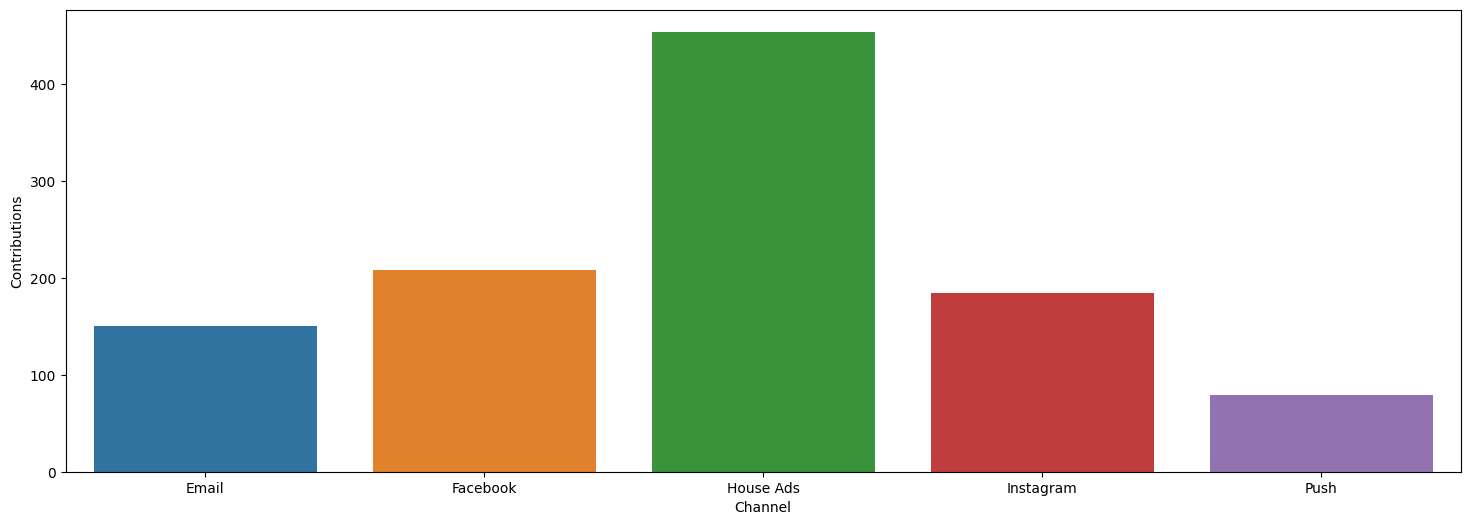

In [123]:
#visualizations of Shapley attribution
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
%matplotlib inline
import seaborn as sns
result = pd.DataFrame(list(dict(calculate_shapley(names, "conversion_sum")).items()),columns = ['Channel','Contributions'])
# Visualization
plt.subplots(figsize=(18, 6))
sns.barplot(x='Channel', y='Contributions', data=result)
plt.show()

In [124]:
calculate_shapley(names, "conversion_sum")

defaultdict(int,
            {'Email': 150.5,
             'Facebook': 208.5,
             'House Ads': 453.83333333333337,
             'Instagram': 184.00000000000003,
             'Push': 79.16666666666667})

In [156]:
data = pd.read_csv('marketing.csv')
data = data.drop(data.columns[-4:], axis=1)


In [157]:
data.dropna(axis = 0, inplace = True)

In [159]:
data["conversion"]=data["converted"].astype('int')

In [160]:
simple_attr = pd.pivot_table(data, values='conversion', index=['marketing_channel'], aggfunc=np.sum)
simple_attr = simple_attr.reset_index()
simple_attr

,marketing_channel,conversion
0,Email,193
1,Facebook,237
2,House Ads,298
3,Instagram,265
4,Push,83


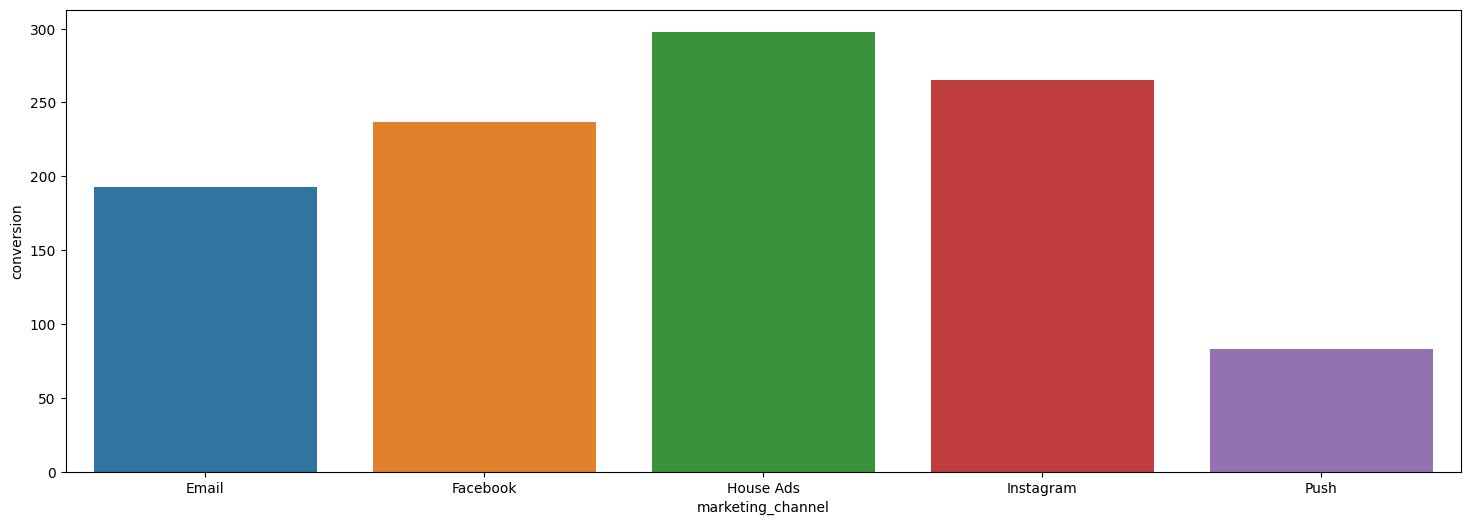

In [161]:
# Visualization of simple attributions
plt.subplots(figsize=(18, 6))
sns.barplot(x='marketing_channel', y='conversion', data=simple_attr)
plt.show()